In [58]:
import os
import subprocess
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import extract_dataset
from datetime import datetime


In [59]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

if not os.path.exists('Preprocessed_GDP_Dataset.csv'):
    subprocess.run(["python3", "preprocess_gdp_dataset.py"])

dataset_file_path = extract_dataset('GlobalTerrorismDataset.zip')
df = pd.read_csv(dataset_file_path, encoding='ISO-8859-1', low_memory=False)

globalterrorismdb_0718dist.csv already exists!


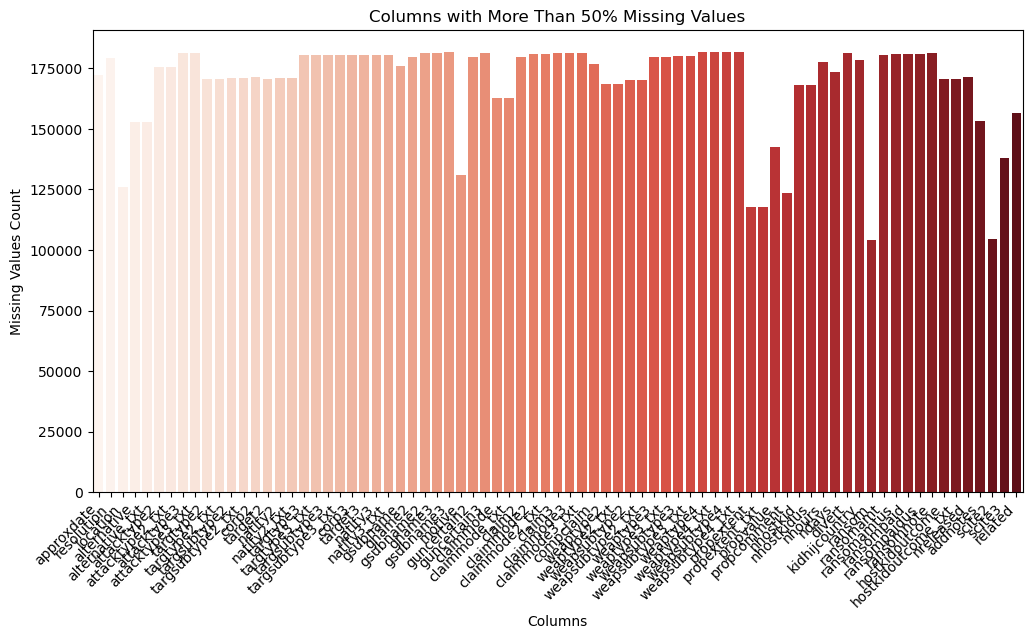

In [60]:
# Calculate missing values and completeness percentage
missing_values = df.isnull().sum()
completeness_percentage = (1 - (missing_values / len(df))) * 100

completeness_analysis = pd.DataFrame({
    'Missing Values Count': missing_values,
    'Completeness Percentage': completeness_percentage
})

columns_50p_missing = completeness_analysis[completeness_analysis['Completeness Percentage'] < 50]

# Bar Plot for Columns with More Than 50% Missing Values
if not columns_50p_missing.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=columns_50p_missing.index,
        y=columns_50p_missing['Missing Values Count'],
        palette='Reds'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Columns with More Than 50% Missing Values')
    plt.xlabel('Columns')
    plt.ylabel('Missing Values Count')
    plt.show()
else:
    print('No columns have more than 50% missing values.')

In [61]:
selected_columns = [
    'iyear', 'imonth', 'iday', 'extended', 'resolution', 'country_txt', 
    'region_txt', 'city', 'success', 'suicide', 'attacktype1_txt', 
    'targtype1_txt', 'natlty1_txt', 'gname', 'nperps', 'weaptype1_txt', 
    'nkill', 'nwound', 'nkillus', 'nwoundus', 'dbsource'
]

column_renaming = {
    'iyear': 'Year', 'imonth': 'Month', 'iday': 'Day', 'extended': 'Extended', 
    'resolution': 'Resolution', 'country_txt': 'Country', 'region_txt': 'Region', 
    'city': 'City', 'success': 'Success', 'suicide': 'Suicide', 
    'attacktype1_txt': 'Attack Type', 'targtype1_txt': 'Target Type', 
    'natlty1_txt': 'Target Nationality', 'gname': 'Attacking Group Name', 
    'nperps': 'Number of Terrorists', 'weaptype1_txt': 'Weapon Type', 
    'nkill': 'Number of Killed People', 'nwound': 'Number of Wounded People', 
    'nkillus': 'Number of Killed US People', 'nwoundus': 'Number of Wounded US People', 
    'dbsource': 'Database Source'
}

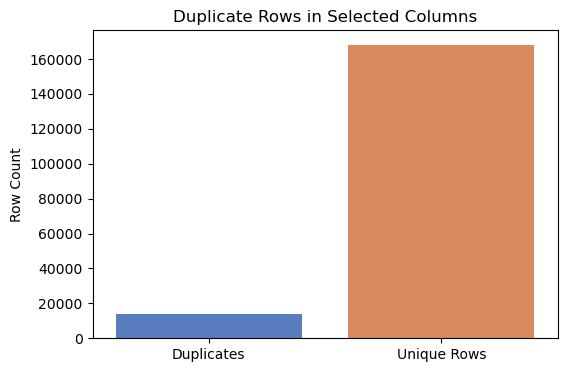

No invalid kill counts found in the selected columns.
All required date columns are present in the selected columns.


In [62]:
df_selected = df[selected_columns]

unique_counts = df_selected.nunique()
duplicate_count = df_selected.duplicated().sum()
if duplicate_count > 0:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Duplicates', 'Unique Rows'], y=[duplicate_count, len(df_selected) - duplicate_count], palette='muted')
    plt.title('Duplicate Rows in Selected Columns')
    plt.ylabel('Row Count')
    plt.show()
else:
    print('No duplicate rows found in the selected columns.')

invalid_kill_counts = df_selected[df_selected['nkill'] < 0]
if invalid_kill_counts.empty:
    print('No invalid kill counts found in the selected columns.')

# Check for missing required date columns
required_columns = ['iyear', 'imonth', 'iday']
missing_columns = [col for col in required_columns if col not in df_selected.columns]
if missing_columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=missing_columns, y=[1] * len(missing_columns), palette='coolwarm')
    plt.title('Missing Required Date Columns')
    plt.xlabel('Required Columns')
    plt.ylabel('Presence (0 = Missing, 1 = Present)')
    plt.yticks([])
    plt.show()
else:
    print('All required date columns are present in the selected columns.')

In [63]:
filtered_df = df_selected.rename(columns=column_renaming)

def is_valid_date(year, month, day):
    """Check if the given year, month, day form a valid date."""
    try:
        datetime(year, month, day)
        return True
    except ValueError:
        return False

def calculate_duration(row):
    """Calculate the duration of an attack if extended and resolution date exists."""
    if not is_valid_date(row['Year'], row['Month'], row['Day']):
        return 0
    
    if row['Extended'] == 1 and pd.notnull(row['Resolution']):
        attack_date = datetime(row['Year'], row['Month'], row['Day'])
        try:
            resolution_date = datetime.strptime(row['Resolution'], "%m/%d/%Y")
            return (resolution_date - attack_date).days
        except ValueError:
            return 1
    return 1

# Apply the duration calculation
filtered_df['Duration'] = filtered_df.apply(calculate_duration, axis=1)
filtered_df = filtered_df.drop(columns=['Extended', 'Resolution'])

def calculate_casualties(row):
    """Calculate the total number of casualties by adding killed and wounded people."""
    if pd.isnull(row['Number of Killed People']) or pd.isnull(row['Number of Wounded People']):
        return -99
    return row['Number of Killed People'] + row['Number of Wounded People']

# Apply the casualties calculation
filtered_df['Number of Casualties'] = filtered_df.apply(calculate_casualties, axis=1)

# Replace null values with -99 or 'Unknown'
filtered_df['Number of Terrorists'] = filtered_df['Number of Terrorists'].fillna(-99)
filtered_df['Number of Killed People'] = filtered_df['Number of Killed People'].fillna(-99)
filtered_df['Number of Wounded People'] = filtered_df['Number of Wounded People'].fillna(-99)
filtered_df['Number of Killed US People'] = filtered_df['Number of Killed US People'].fillna(-99)
filtered_df['Number of Wounded US People'] = filtered_df['Number of Wounded US People'].fillna(-99)
filtered_df['Target Nationality'] = filtered_df['Target Nationality'].fillna('Unknown')


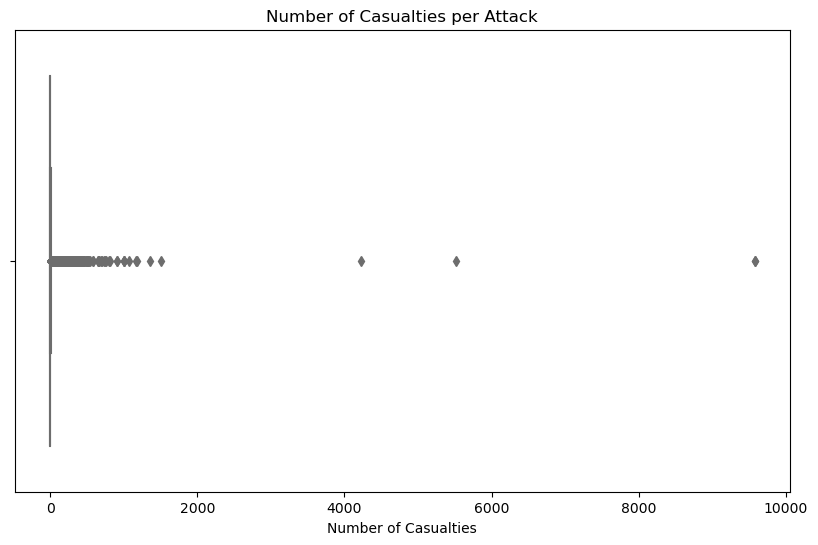

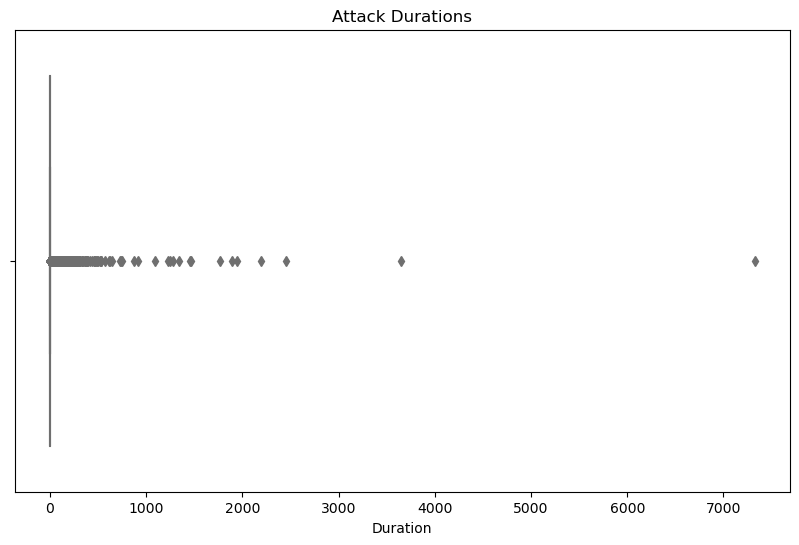

In [64]:
# Boxplot of Number of Casualties
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df[filtered_df['Number of Casualties'] != -99]['Number of Casualties'], 
            color='salmon')
plt.title('Number of Casualties per Attack')
plt.xlabel('Number of Casualties')
plt.show()

# Boxplot of Attack Durations (excluding 0 or negative durations)
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df[filtered_df['Duration'] > 0]['Duration'], 
            color='skyblue')
plt.title('Attack Durations')
plt.xlabel('Duration')
plt.show()

In [75]:
gdp_df = pd.read_csv('Preprocessed_GDP_Dataset.csv')
merged_df = pd.merge(filtered_df, gdp_df, how='left', on=['Year', 'Country'])

merged_df['Decade'] = (merged_df['Year'] // 10) * 10  
attack_counts = merged_df.groupby(['Decade', 'Country']).size().reset_index(name='Attack Count')
gdp_by_decade = merged_df.groupby(['Decade', 'Country'])['GDP'].mean().reset_index()
final_df = pd.merge(attack_counts, gdp_by_decade, on=['Decade', 'Country'], how='left')


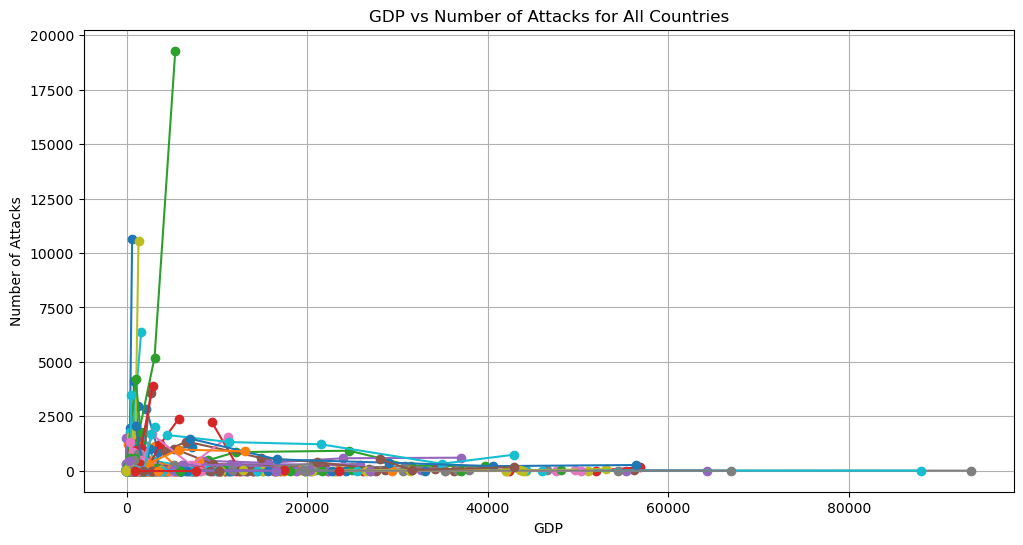

In [86]:
plot_all_countries = True     # Change to False to plot a specific country
specific_country = 'Albania'  # Desired Country

plt.figure(figsize=(12, 6))

if plot_all_countries:
    for country in final_df['Country'].unique():
        country_data = final_df[final_df['Country'] == country]
        plt.plot(country_data['GDP'], country_data['Attack Count'], marker='o', label=country)
else:
    country_data = final_df[final_df['Country'] == specific_country]
    plt.plot(country_data['GDP'], country_data['Attack Count'], marker='o', label=specific_country)

    # Annotate the decades on the plot
    for i, row in country_data.iterrows():
        plt.annotate(row['Decade'], (row['GDP'], row['Attack Count']), textcoords="offset points", 
                     xytext=(0,5), ha='center', fontsize=8)

if plot_all_countries:
    plt.title('GDP vs Number of Attacks for All Countries')
else:
    plt.title(f'GDP vs Number of Attacks for {specific_country}')

plt.xlabel('GDP')
plt.ylabel('Number of Attacks')
plt.grid()
# plt.legend(title='Country') if plot_all_countries else plt.legend(title=specific_country)
plt.show()

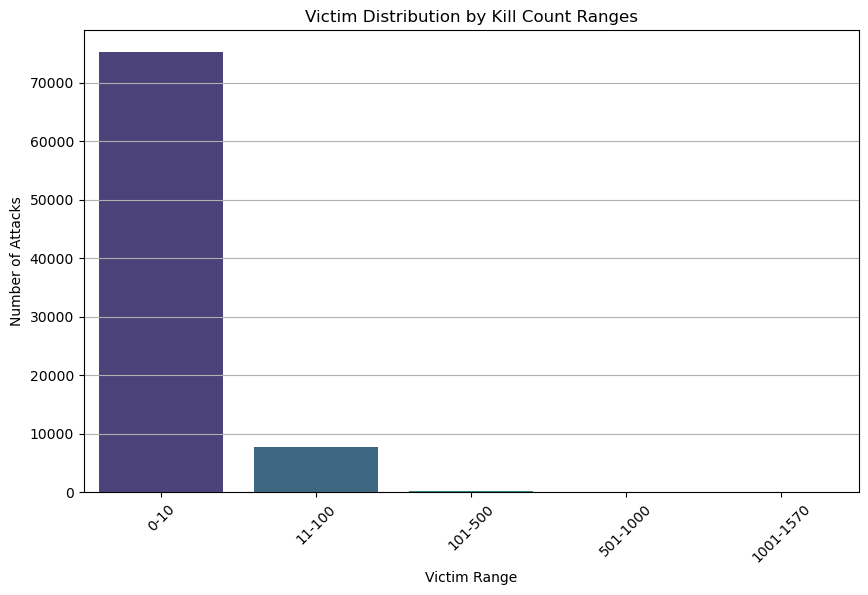

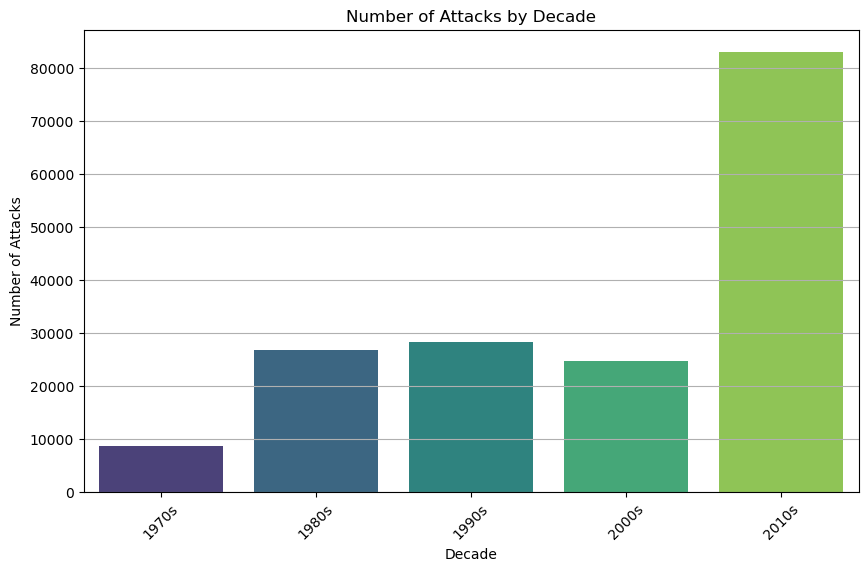

In [88]:
# --- Discretization ---
bins = [0, 10, 100, 500, 1000, 1570]
labels = ['0-10', '11-100', '101-500', '501-1000', '1001-1570']
df['victim_range'] = pd.cut(df['nkill'], bins=bins, labels=labels, right=True)

df_cleaned = df.dropna(subset=['nkill', 'victim_range'])

victim_distribution = df_cleaned['victim_range'].value_counts()

# Decade Distribution
bins_decades = [1970, 1980, 1990, 2000, 2010, 2020]  
labels_decades = ['1970s', '1980s', '1990s', '2000s', '2010s']  
df['decade'] = pd.cut(df['iyear'], bins=bins_decades, labels=labels_decades, right=False)

df_cleaned = df.dropna(subset=['nkill', 'decade'])

decade_distribution = df_cleaned['decade'].value_counts()

# Plot for Victim Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=victim_distribution.index, y=victim_distribution.values, palette='viridis')
plt.title('Victim Distribution by Kill Count Ranges')
plt.xlabel('Victim Range')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Plot for Decade Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=decade_distribution.index, y=decade_distribution.values, palette='viridis')
plt.title('Number of Attacks by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [91]:
df['attacktype1'] = df['attacktype1'].replace('', np.nan).fillna('Unknown')
df['weaptype1'] = df['weaptype1'].replace('', np.nan).fillna('Unknown')

# One-hot encode the 'attacktype1' and 'weaptype1' columns
attack_weap_dummies = pd.get_dummies(df[['attacktype1', 'weaptype1']], drop_first=True)

other_features = df[['nperps', 'nkill', 'suicide', 'success']]
features = pd.concat([other_features, attack_weap_dummies], axis=1)
features = features.applymap(lambda x: np.nan if x < 0 else x)
features.fillna(features.median(), inplace=True)

scaler = StandardScaler()
features[['nperps', 'nkill']] = scaler.fit_transform(features[['nperps', 'nkill']])
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
reduced_df = pd.DataFrame(data=reduced_features, columns=['PC1', 'PC2'])

In [92]:
reduced_df.head()

,PC1,PC2
0,3.619660,-5.901129
1,6.804814,-2.049591
2,3.619660,-5.901129
3,-0.502199,0.096468
4,3.587298,1.902967
